# Сочетание различных моделей в ансамблевом обучении

In [1]:
%load_ext watermark
%watermark -a "ЦДО МГТУ" -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn

Author: ЦДО МГТУ

Last updated: 2023-12-03

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.18.1

numpy     : 1.26.2
pandas    : 2.1.3
matplotlib: 3.8.2
scipy     : 1.11.4
sklearn   : 1.3.2



*Для корректной работы `watermark` установите расширение*  

    conda install watermark -c conda-forge  

или  

    pip install watermark   

*Детально см.: https://github.com/rasbt/watermark.*

<br>
<br>

### Содержание

- [Идея ансамблевого обучения](#Идея-ансамблевого-обучения)
- [Комбинация решений отдельных моделей по методу голосования](#Комбинация-решений-отдельных-моделей-по-методу-голосования)
    - [Реализация простейшей процедуры голосования классификаторов](#Реализация-простейшей-процедуры-голосования-классификаторов)
    - [Использование принципа голосования большинством для формирования прогнозов](#Использование-принципа-голосования-большинством-для-формирования-прогнозов)
    - [Оценка и настройка ансамблевого классификатора](#Оценка-и-настройка-ансамблевого-классификатора)
- [Bagging -- построение ансамбля классификаторов на разных bootstrap](#Bagging----построение-ансамбля-классификаторов-на-разных-bootstrap)
    - [Бэггинг -- кратко](#Бэггинг----кратко)
    - [Бэггинг для классификации примеров в датасете по винам](#Бэггинг-для-классификации-примеров-в-датасете-по-винам)
- [Улучшение результатов слабых моделей адаптивным бустингом](#Улучшение-результатов-слабых-моделей-адаптивным-бустингом)
    - [Как работает бустинг?](#Как-работает-бустинг?)
    - [Реализация AdaBoost с использованием scikit-learn](#Реализация-AdaBoost-с-использованием-scikit-learn)
- [Заключение](#Заключение)

<br>
<br>

In [2]:
from IPython.display import Image # Библиотека для отображения картинок
%matplotlib inline

# Идея ансамблевого обучения

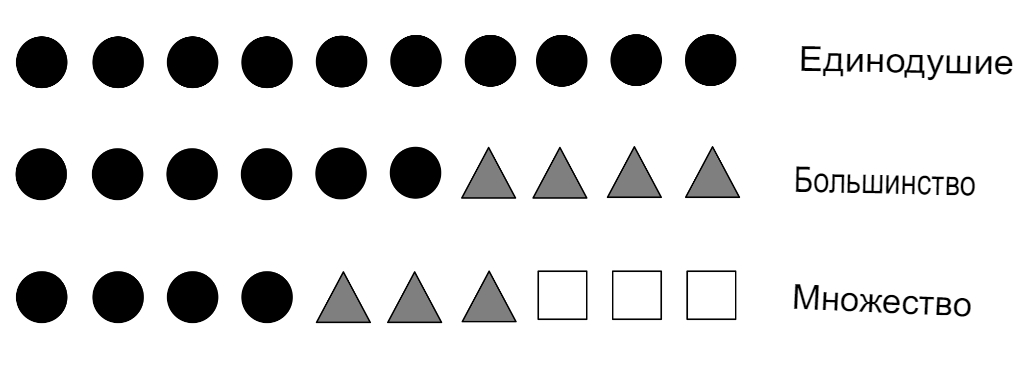

In [3]:
Image(filename='images/ans_01_rus.jpg', width = 500) # Локальный файл

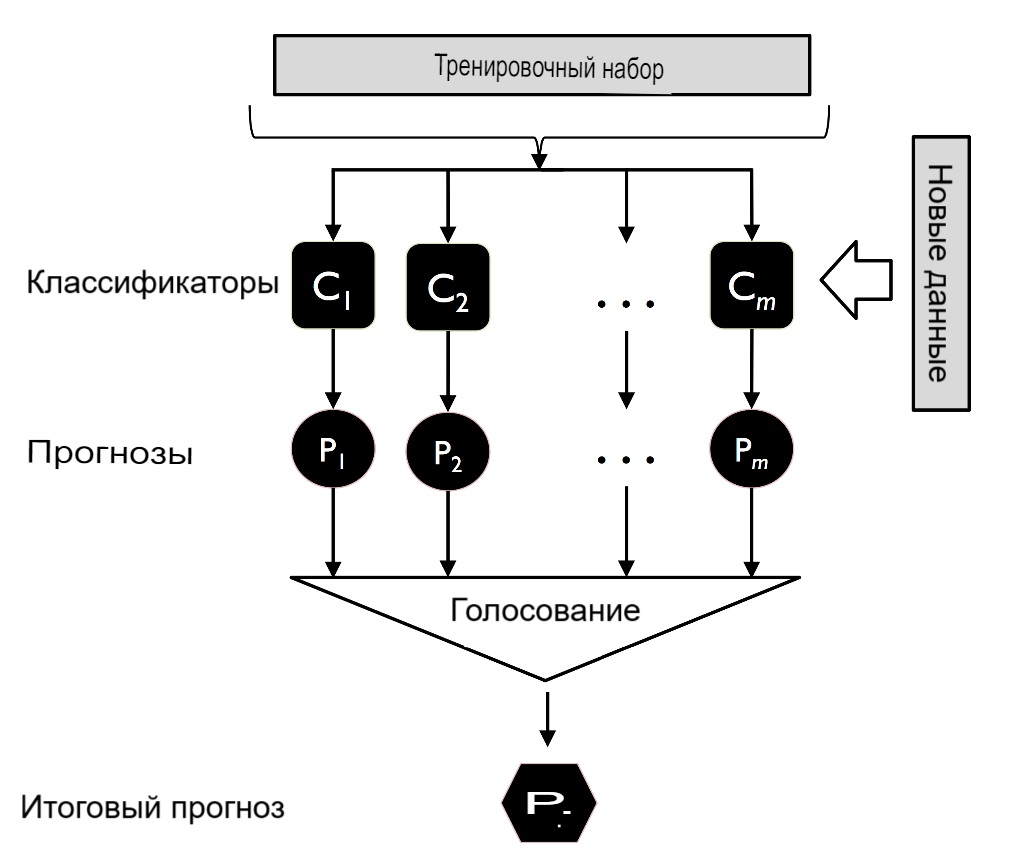

In [4]:
Image(filename='images/ans_02_rus.jpg', width = 500) # Локальный файл

In [5]:
# Функция оценки точности прогноза в зависимости от числа независимых слабых моделей
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [7]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

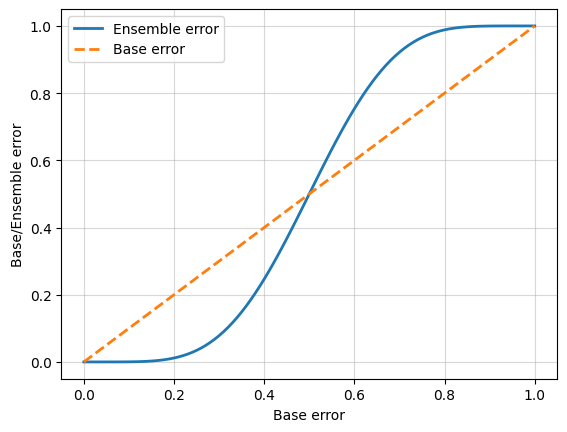

In [8]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('images/07_03.png', dpi=300)
plt.show()

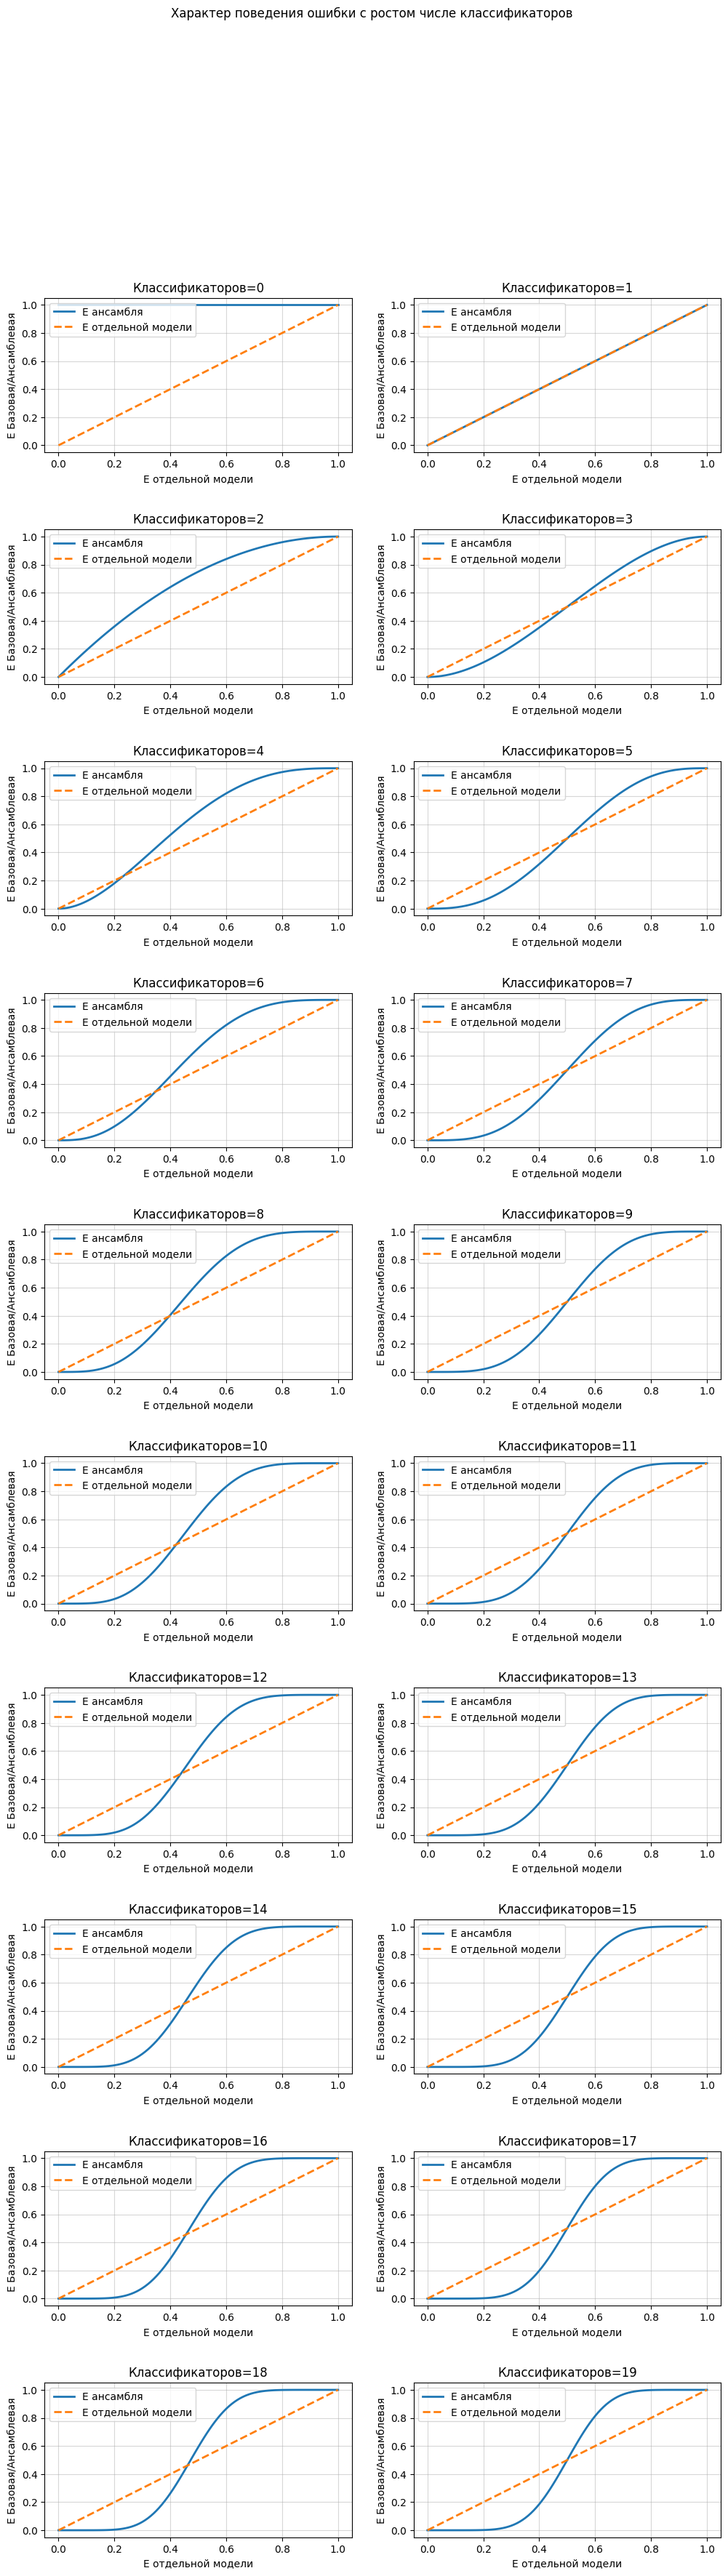

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Создаем фигуру и оси
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(12, 40))
axs = axs.flatten()

# Цикл по всем элементам массива axs
for i in range(20):
    # Вычисляем номер классификатора для данной диаграммы
    classifiers = i # (i // 2) + 1

    # Генерируем данные для диаграммы
    error_range = [0.01 * k for k in range(0, 101)]
    ens_errors = [ensemble_error(n_classifier=classifiers, error=error)
                  for error in error_range]

    # Рисуем диаграмму на соответствующей оси
    axs[i].plot(error_range, ens_errors, label='E ансамбля', linewidth=2)
    axs[i].plot(error_range, error_range, linestyle='--', label='E отдельной модели', linewidth=2)
    axs[i].set_xlabel('E отдельной модели')
    axs[i].set_ylabel('E Базовая/Ансамблевая')
    axs[i].set_title(f'Классификаторов={classifiers}')
    axs[i].legend(loc='upper left')
    axs[i].grid(alpha=0.5)

# Устанавливаем общий заголовок для фигуры
fig.suptitle("Характер поведения ошибки с ростом числе классификаторов")

# Увеличиваем интервалы между строками
fig.subplots_adjust(hspace=0.5)


# Показываем фигуру
plt.show()

# Комбинация решений отдельных моделей по методу голосования

## Реализация простейшей процедуры голосования классификаторов

In [10]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [11]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [12]:
np.argmax(p)

0

In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ Классификатор с голосованием по методу большинства

    Параметры
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Различные классификаторы для ансамбля

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      Для 'classlabel' прогноз основан на argmax меток классов. 
      В противном случае, если "вероятность", 
      то argmax суммы вероятностей используется для прогнозирования метки класса 
      (рекомендуется для калиброванных классификаторов).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      Если предоставлен список значений `int` или `float`, то классификаторы
      взвешиваются по важности, использя единообразные веса, если `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Параметры
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Матрица обучающих примеров

        y : array-like, shape = [n_examples]
            Вектор целевых значений меток класса

        Выходы
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("решение должно быть 'probability' или 'classlabel'"
                             "; получено (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Количество классификаторов и весов должно быть одинаковым'
                             '; получено %d весов, %d классификаторов'
                             % (len(self.weights), len(self.classifiers)))

        # Используйте LabelEncoder, чтобы убедиться, что метки классов начинаются с 0, 
        # что важно для вызова np.argmax в self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Предсказанные метки классов для X.

        Параметры
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Матрица обучающих примеров

        Выходы
        ----------
        maj_vote : array-like, shape = [n_examples]
            Предсказанные метки классов.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Предсказывает вероятность класса для X.

        Параметры
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Обучающие векторы, где n_examples - количество примеров, 
            а n_features - количество объектов.
            
        Выходы
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Средневзвешенная вероятность для каждого класса в каждом примере.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Получение имен параметров классификатора для GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

<br>
<br>

## Использование принципа голосования большинством для формирования прогнозов

In [14]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Логистическая регрессия', 'Дерево решений', 'К-ближайших']

print('10-кратная кросс-валидация:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-кратная кросс-валидация:

ROC AUC: 0.92 (+/- 0.15) [Логистическая регрессия]
ROC AUC: 0.87 (+/- 0.18) [Дерево решений]
ROC AUC: 0.85 (+/- 0.13) [К-ближайших]


In [16]:
# Голосование по правилу большинства (жесткое)

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Голосование большинством']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Логистическая регрессия]
ROC AUC: 0.87 (+/- 0.18) [Дерево решений]
ROC AUC: 0.85 (+/- 0.13) [К-ближайших]
ROC AUC: 0.98 (+/- 0.05) [Голосование большинством]


<br>
<br>

# Оценка и настройка ансамблевого классификатора¶

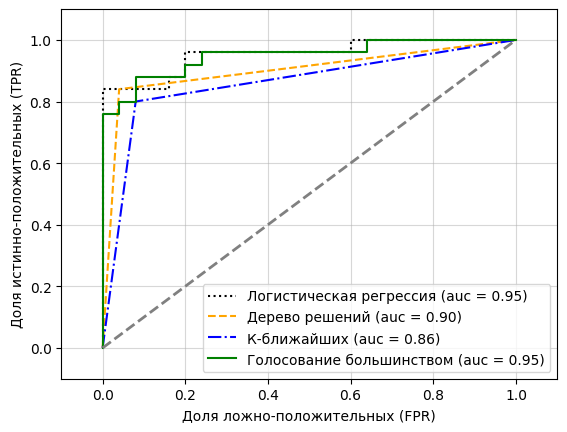

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    #предполагая, что метка положительного класса равна 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Доля ложно-положительных (FPR)')
plt.ylabel('Доля истинно-положительных (TPR)')


#plt.savefig('images/ans_04', dpi=300)
plt.show()

In [18]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

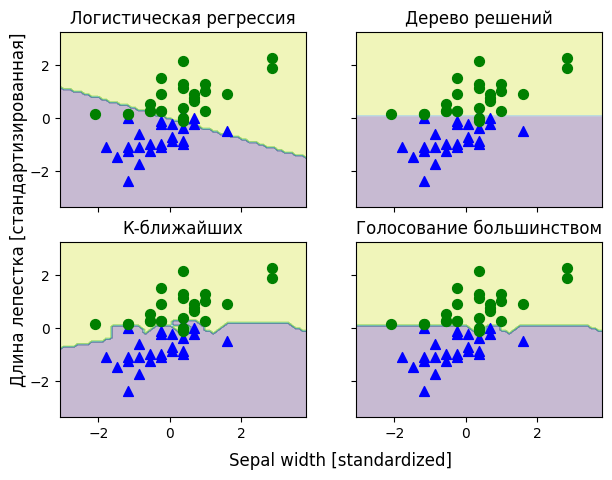

In [19]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Длина лепестка [стандартизированная]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [20]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [21]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    #iid=False,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [22]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


**Примечание**  
По умолчанию значение по умолчанию для `refit` в `GridSearchCV` равно `True` (т.е. `GridSeachCV(..., refit=True)`), что означает, что мы можем использовать установленную оценку `GridSearchCV` для составления прогнозов с помощью метода `predict`, например:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

Кроме того, к "наилучшему" оценщику можно получить прямой доступ через атрибут `best_estimator_`.

In [23]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [24]:
mv_clf = grid.best_estimator_

In [25]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [26]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

<br>
<br>

# Bagging -- построение ансамбля классификаторов на разных bootstrap

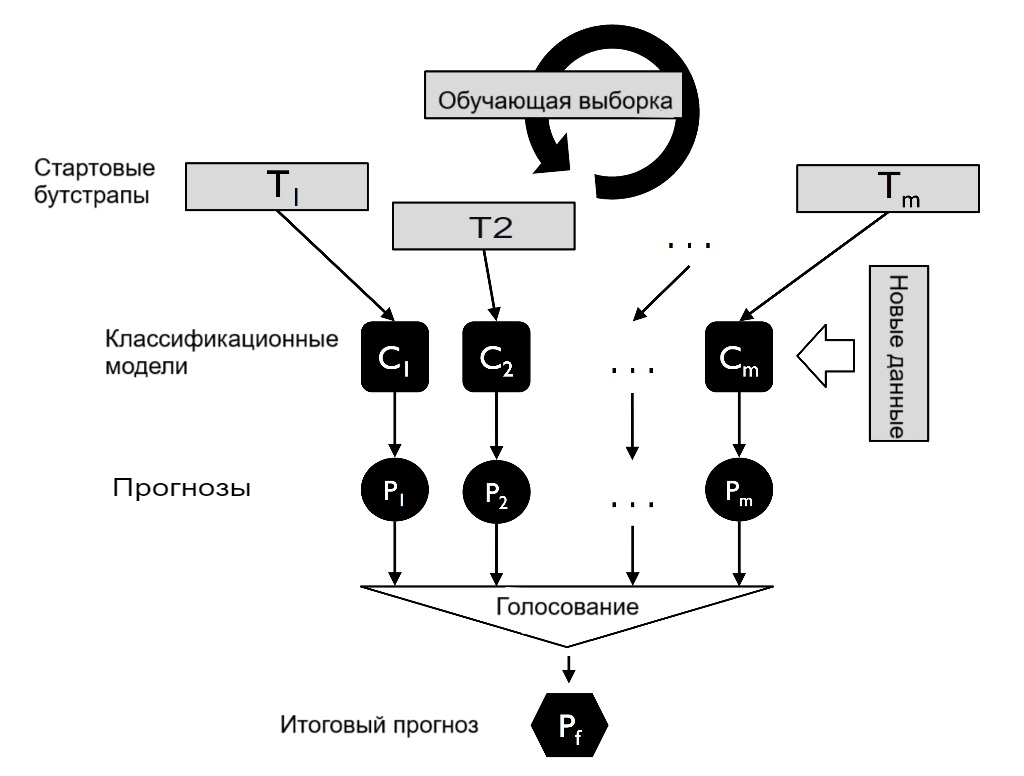

In [27]:
Image(filename='./images/ans_06_rus.jpg', width=500) 

## Бэггинг -- кратко

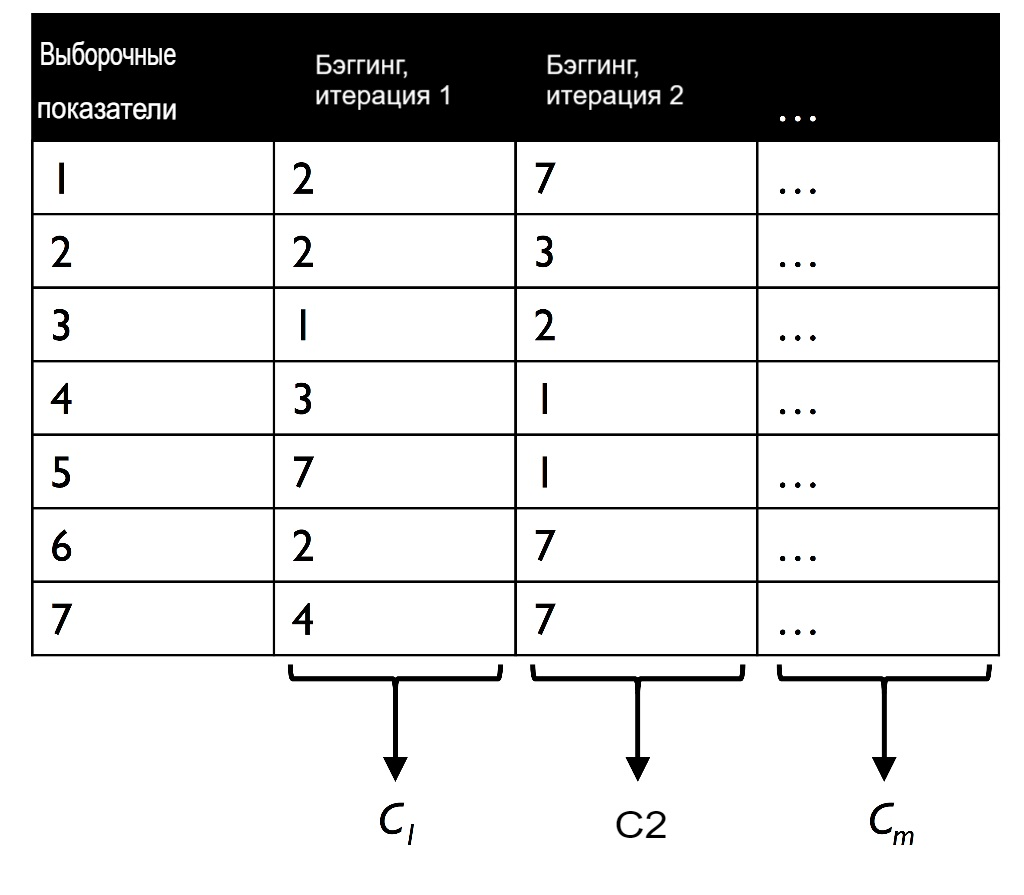

In [28]:
Image(filename='./images/ans_07_rus.jpg', width=400) 

## Бэггинг для классификации примеров в датасете по винам

In [29]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# Если датасет Wine временно недоступен на сайте репозитория UCI
# раскомментируйте следующую строку кода для загрузки датасета из локального CSV-файла

# df_wine = pd.read_csv('wine.data.csv', header=None)

# вырезаем 1 класс
df_wine = df_wine[df_wine['Class label'] != 1]
display(df_wine.head(5))

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [32]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833


C:\Users\BatrakovDR\PycharmProjects\DS_tools\venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging train/test accuracies 1.000/0.917


C:\Users\BatrakovDR\PycharmProjects\DS_tools\venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


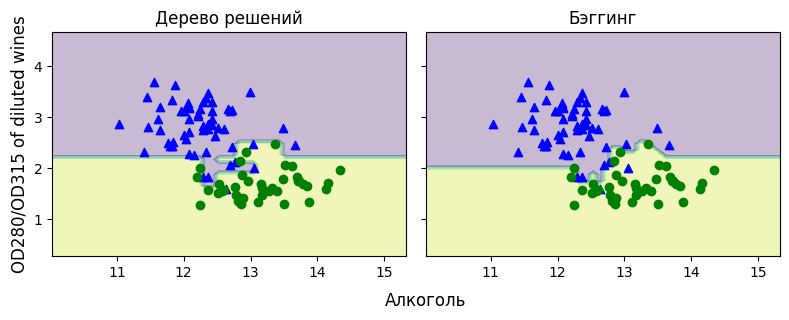

In [33]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Дерево решений', 'Бэггинг']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Алкоголь',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

# Улучшение результатов слабых моделей адаптивным бустингом

## Как работает бустинг?

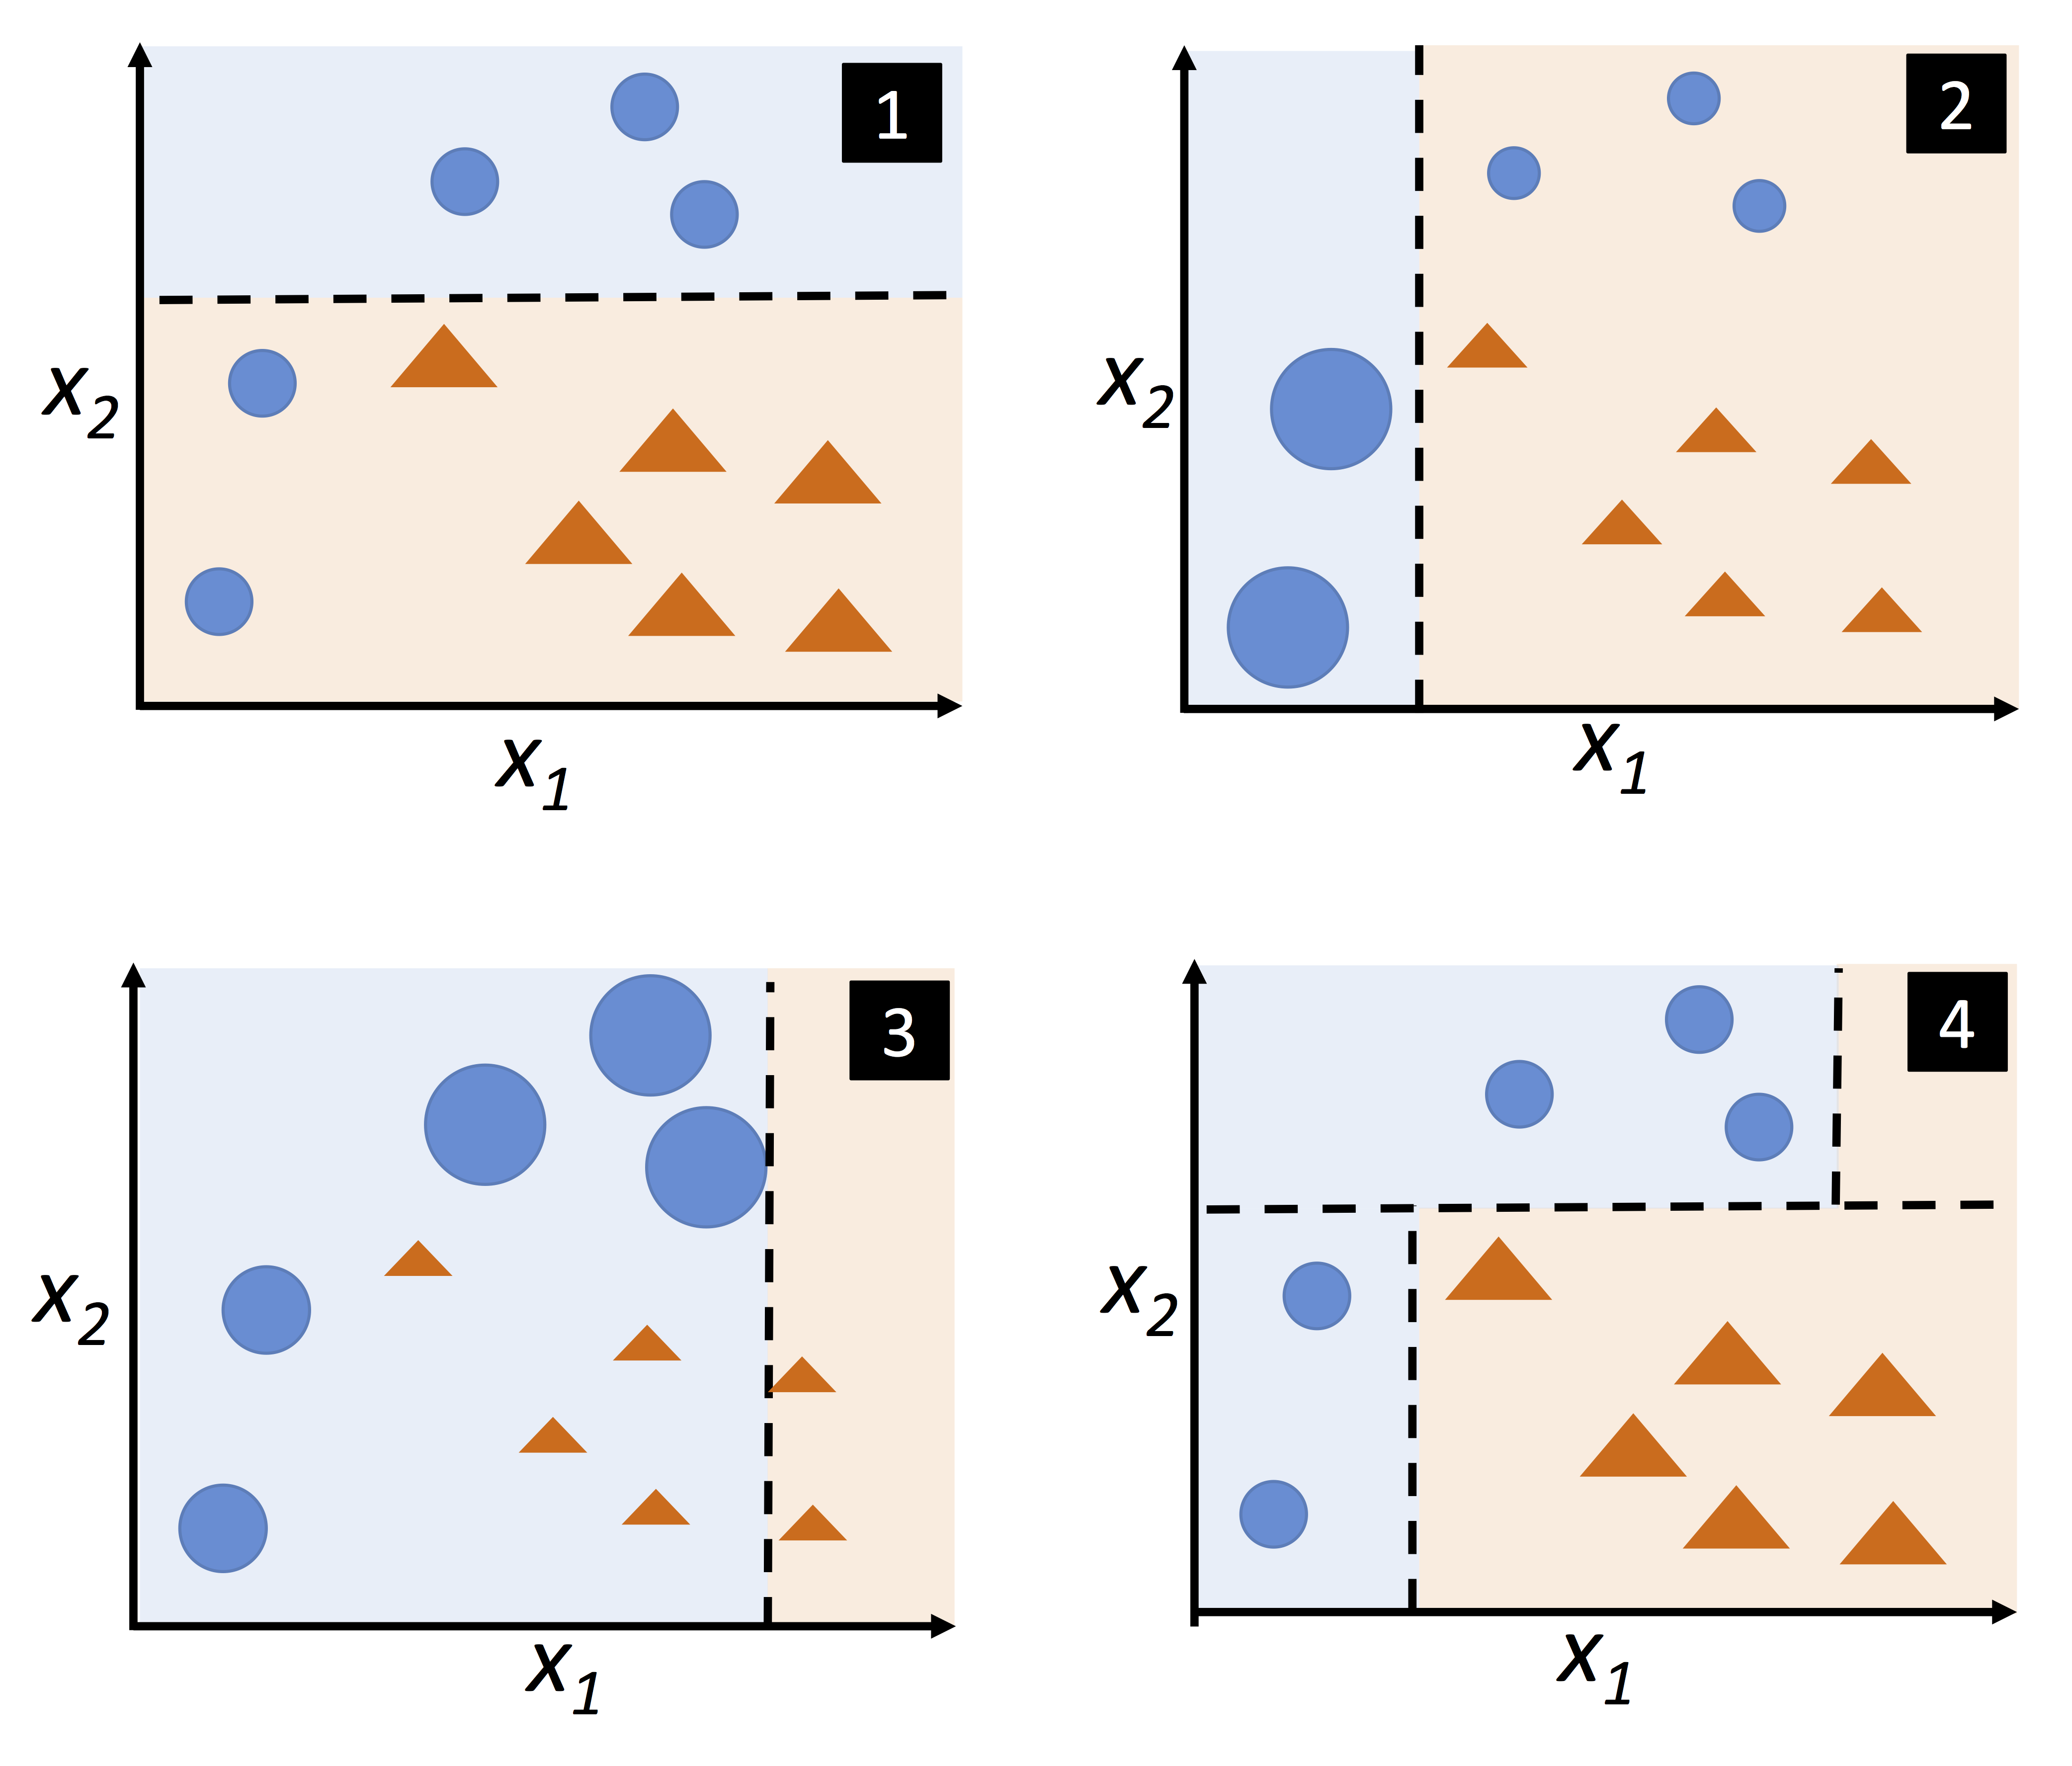

In [34]:
Image(filename='images/ans_09_rus.png', width=400) 

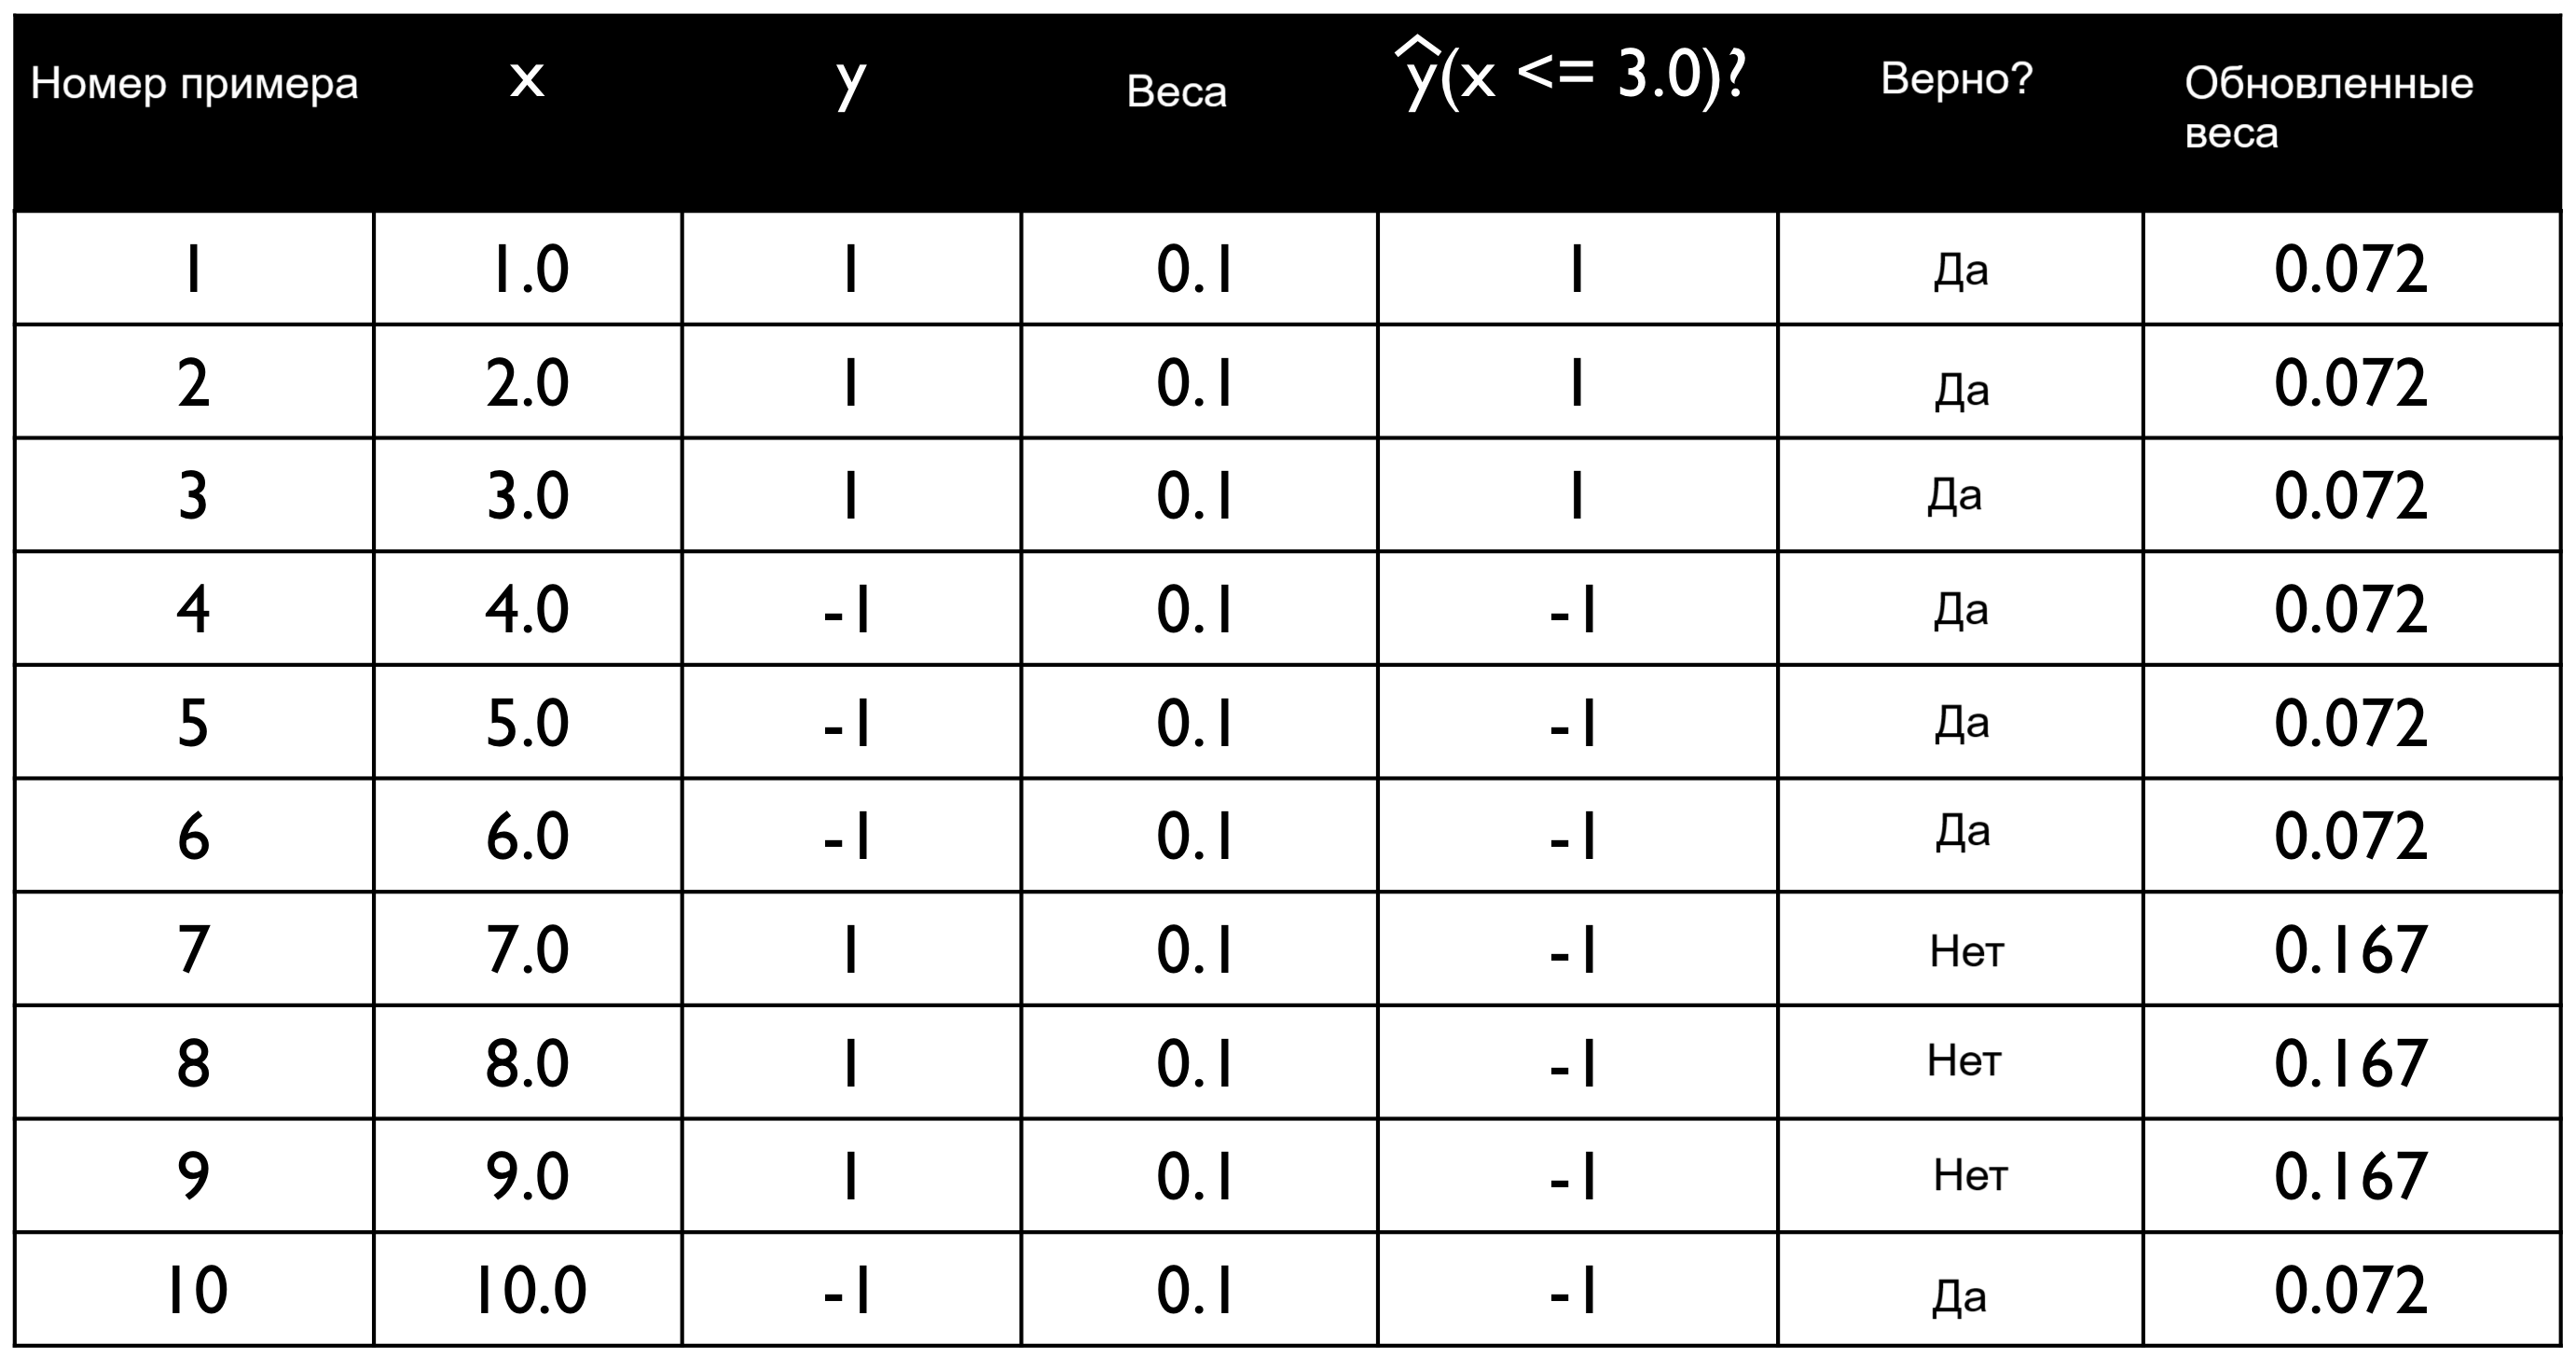

In [35]:
Image(filename='images/ans_10_rus.png', width=500) 

## Реализация AdaBoost с использованием scikit-learn

In [36]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [37]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('Точность AdaBoost train/test %.3f/%.3f'
      % (ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.875


C:\Users\BatrakovDR\PycharmProjects\DS_tools\venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Точность AdaBoost train/test 1.000/0.917


C:\Users\BatrakovDR\PycharmProjects\DS_tools\venv\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


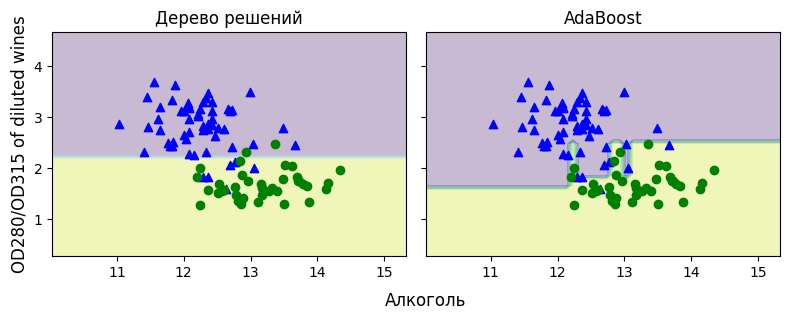

In [38]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Дерево решений', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Алкоголь',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

<br>
<br>

# Заключение

На этом занятии мы рассмотрели некоторые из наиболее популярных и широко используемых методов ансамблевого обучения. 
Ансамблевые методы объединяют различные модели классификации, позволяя компенсировать их индивидуальные недостатки, что часто приводит к созданию стабильных и хорошо работающих моделей, которые очень привлекательны в решении задач.
В начале этой главы мы реализовали MajorityVoteClassifier в Python, позволяющий комбинировать различные алгоритмы классификации. Затем мы рассмотрели бэггинг, полезный метод уменьшения дисперсии модели путем извлечения случайных бутстрапов из обучающего набора данных и объединения индивидуально обученных классификаторов путем голосования большинством голосов. 
Наконец, мы узнали об AdaBoost, который представляет собой алгоритм, основанный на комбинации слабых моделей, которые впоследствии учатся на ошибках.